In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz

%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

pd.options.display.max_columns= None

In [2]:
df = pd.read_csv("autos.csv")

In [3]:
df

,symboling,normalized-losses,make-id,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,1,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,1,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,-1,95.0,22,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
212,-1,95.0,22,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
213,-1,95.0,22,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
214,-1,95.0,22,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          216 non-null    int64  
 1   normalized-losses  175 non-null    float64
 2   make-id            216 non-null    int64  
 3   fuel-type          216 non-null    object 
 4   aspiration         216 non-null    object 
 5   num-of-doors       214 non-null    object 
 6   body-style         216 non-null    object 
 7   drive-wheels       216 non-null    object 
 8   engine-location    216 non-null    object 
 9   wheel-base         216 non-null    float64
 10  length             216 non-null    float64
 11  width              216 non-null    float64
 12  height             216 non-null    float64
 13  curb-weight        216 non-null    int64  
 14  engine-type        216 non-null    object 
 15  num-of-cylinders   216 non-null    object 
 16  engine-size        216 non

In [5]:
df.describe()

,symboling,normalized-losses,make-id,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,216.000000,175.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,212.000000,212.000000,216.000000,214.000000,214.000000,216.000000,216.000000,212.00000
mean,0.726852,120.080000,13.643519,99.150000,174.800463,66.012500,53.852778,2580.129630,127.689815,3.347028,3.249811,10.146852,105.476636,5133.878505,25.013889,30.500000,13459.09434
std,1.302742,35.212563,6.412760,6.131611,12.449360,2.146513,2.450817,518.568774,40.776659,0.280941,0.310364,3.979112,39.332182,470.375341,6.471748,6.817215,7845.35856
min,-2.000000,65.000000,1.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.00000
25%,0.000000,94.000000,9.000000,94.500000,167.175000,64.200000,52.000000,2190.750000,98.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7871.00000
50%,1.000000,110.000000,14.000000,97.200000,173.450000,65.550000,54.100000,2459.000000,120.000000,3.330000,3.270000,9.000000,97.000000,5200.000000,24.000000,30.000000,10921.50000
75%,2.000000,148.000000,20.000000,103.300000,186.600000,67.200000,55.700000,3012.000000,141.000000,3.620000,3.402500,9.400000,119.000000,5500.000000,30.000000,34.000000,16646.25000
max,3.000000,256.000000,22.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.00000


In [6]:
df.isnull().sum()

symboling             0
normalized-losses    41
make-id               0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [7]:
df.duplicated().sum()

11

In [8]:
df.shape

(216, 26)

In [9]:
df = df.dropna()

In [10]:
df.shape

(170, 26)

In [11]:
df

,symboling,normalized-losses,make-id,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,2,164.0,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
6,1,158.0,2,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0
8,1,158.0,2,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0
10,2,192.0,3,gas,std,two,sedan,rwd,front,101.2,176.8,64.8,54.3,2395,ohc,four,108,mpfi,3.50,2.80,8.8,101.0,5800.0,23,29,16430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,-1,95.0,22,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
212,-1,95.0,22,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
213,-1,95.0,22,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
214,-1,95.0,22,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


In [12]:
df.reset_index(drop=True)

,symboling,normalized-losses,make-id,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,2,164.0,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
1,2,164.0,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
2,1,158.0,2,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0
3,1,158.0,2,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0
4,2,192.0,3,gas,std,two,sedan,rwd,front,101.2,176.8,64.8,54.3,2395,ohc,four,108,mpfi,3.50,2.80,8.8,101.0,5800.0,23,29,16430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,-1,95.0,22,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
166,-1,95.0,22,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
167,-1,95.0,22,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
168,-1,95.0,22,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


In [13]:
df.duplicated().sum()

11

In [14]:
df = df.drop_duplicates()

In [15]:
df.shape

(159, 26)

In [17]:
df.reset_index(drop=True)

,symboling,normalized-losses,make-id,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,2,164.0,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
1,2,164.0,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
2,1,158.0,2,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0
3,1,158.0,2,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0
4,2,192.0,3,gas,std,two,sedan,rwd,front,101.2,176.8,64.8,54.3,2395,ohc,four,108,mpfi,3.50,2.80,8.8,101.0,5800.0,23,29,16430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,-1,95.0,22,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
155,-1,95.0,22,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
156,-1,95.0,22,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
157,-1,95.0,22,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


In [18]:
216 - 159

57

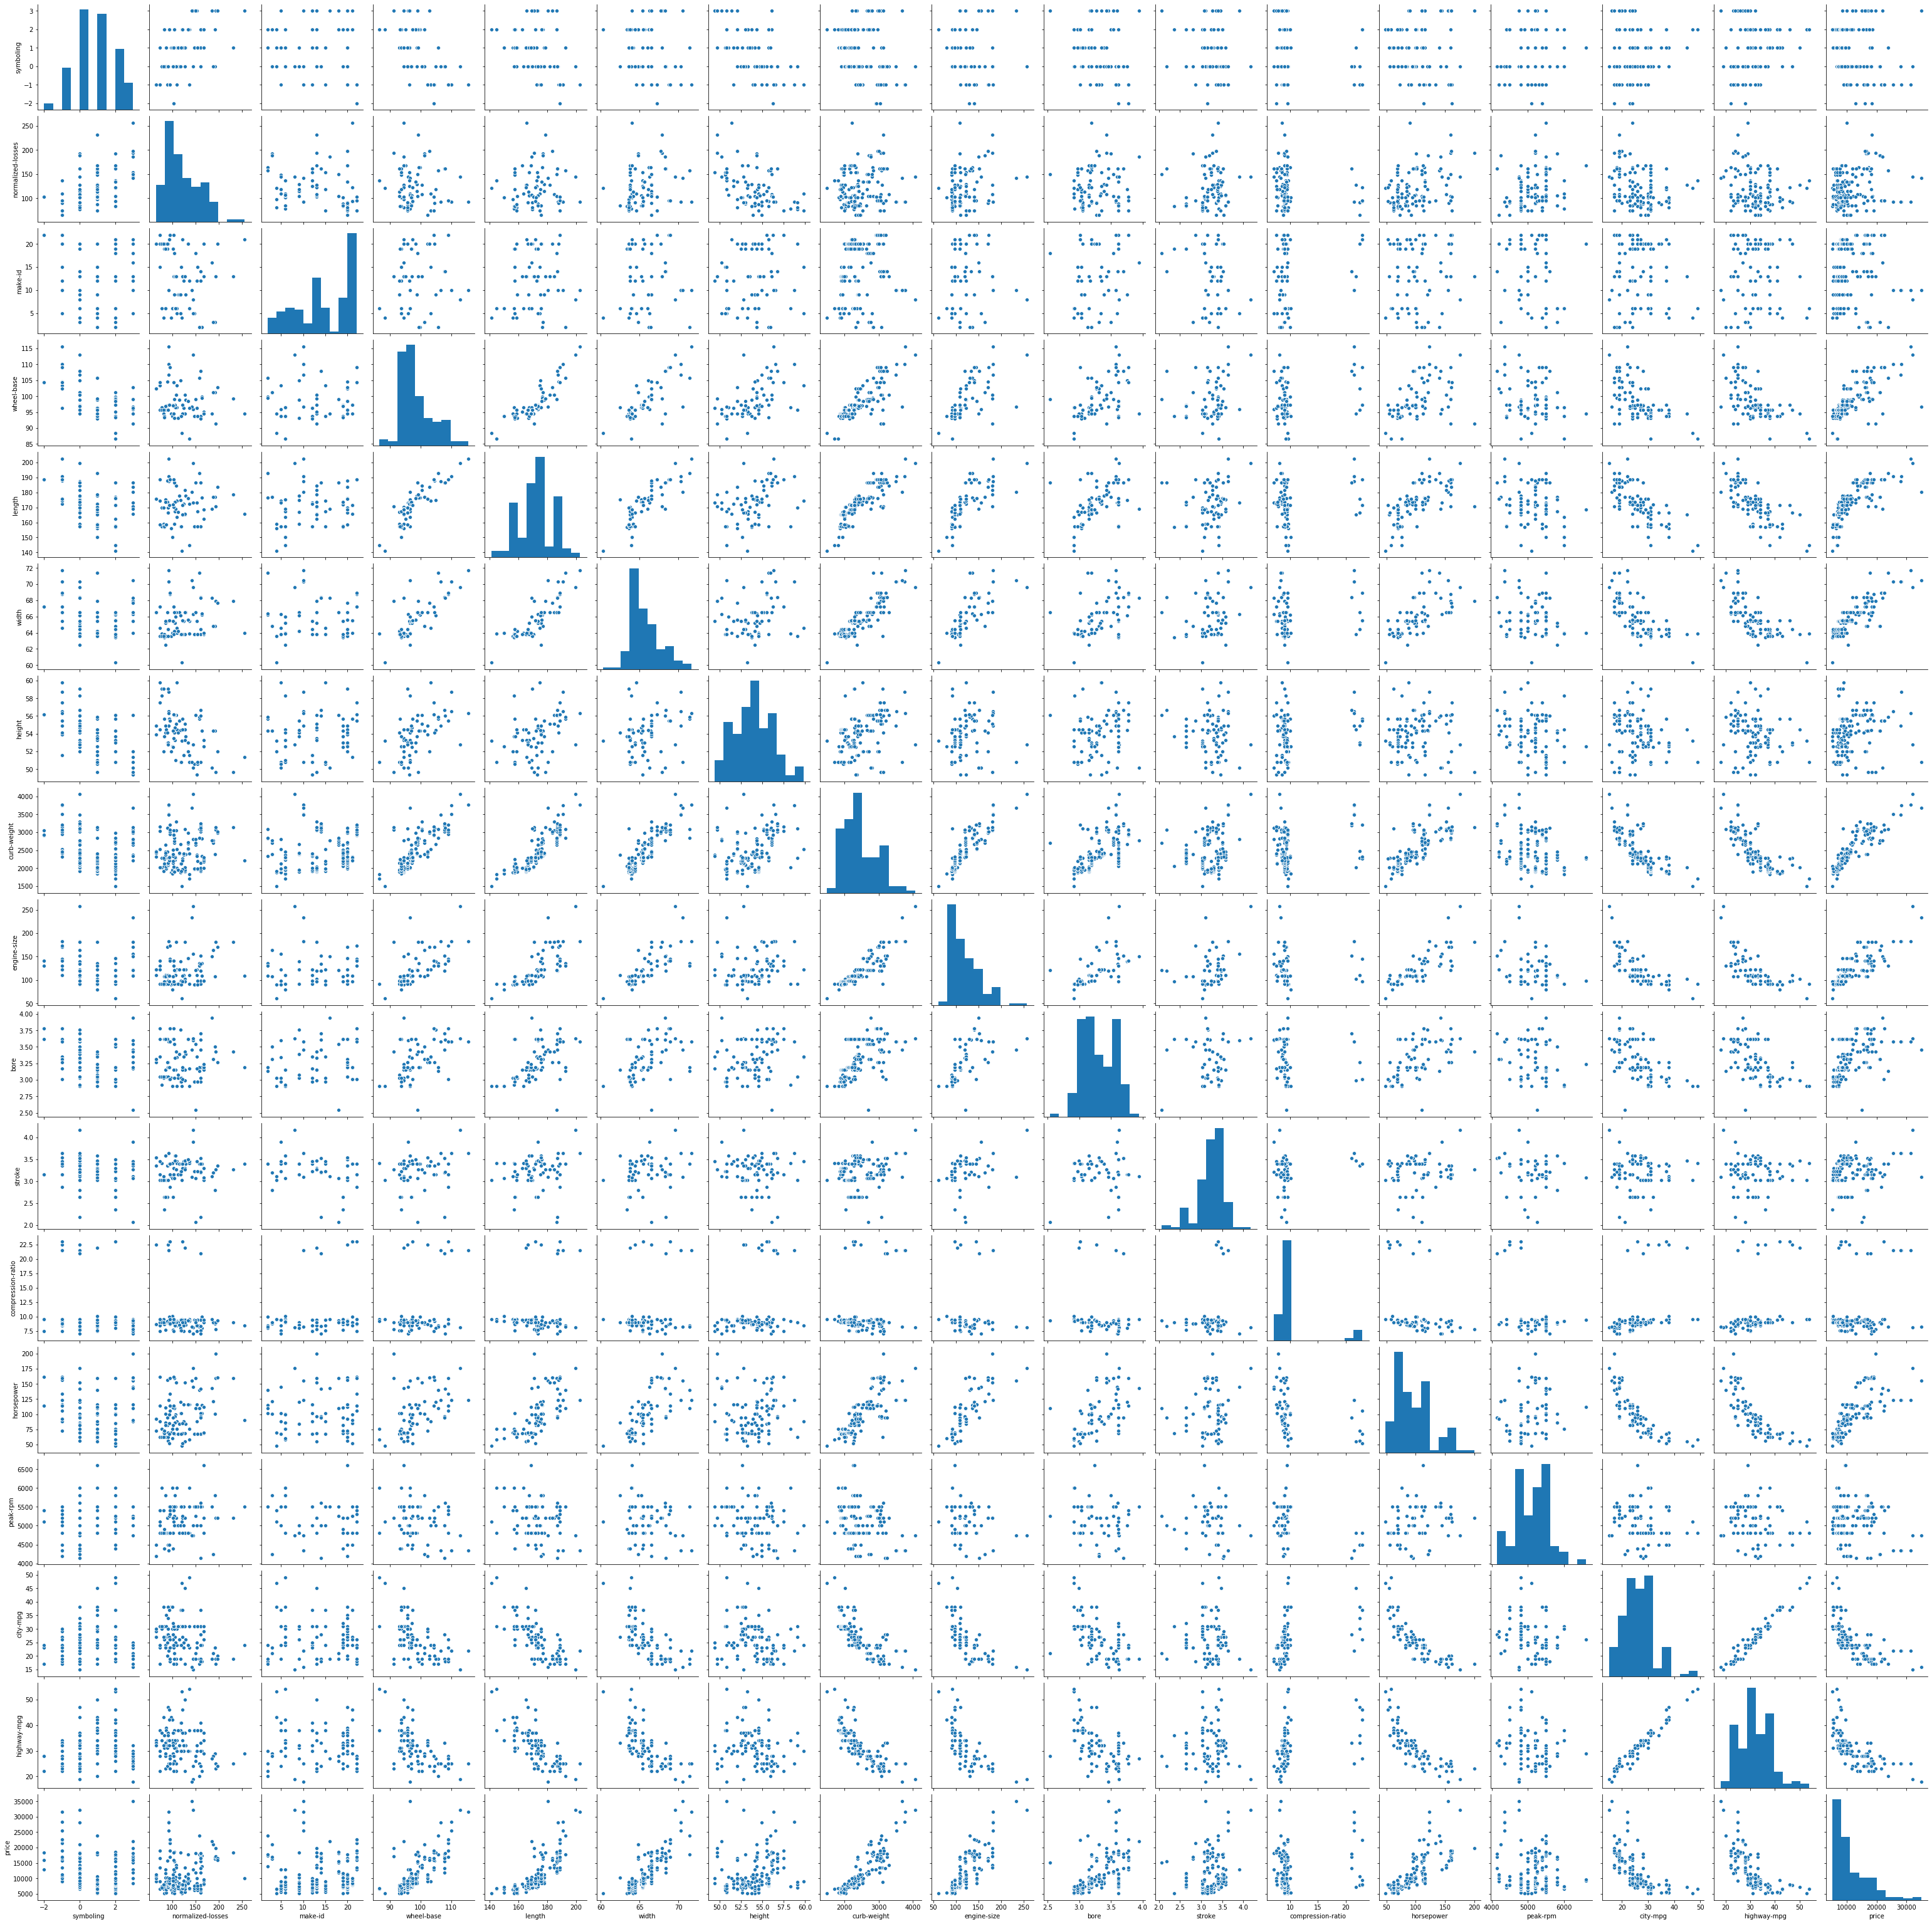

In [19]:
sns.pairplot(df)
plt.show()

In [ ]:
X = df.iloc[:,0:7]
y = df.iloc[:,7]

In [ ]:
X.values, y.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
xgb = XGBClassifier(random_state=0, n_estimators=200)

In [ ]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=20)

In [ ]:
y_pred = xgb.predict(X_test)

In [ ]:
y_pred

In [ ]:
plot_confusion_matrix(xgb,X_test,y_test)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
plot_roc_curve(xgb,X_test,y_test)
plt.show()